In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time
from datetime import timedelta

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [ ]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime(x, '%d-%b-%y')

In [ ]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [ ]:
# create a differenced series
#def difference(dataset, interval=1):
#	diff = list()
#	for i in range(interval, len(dataset)):
#		value = dataset[i] - dataset[i - interval]
#		diff.append(value)
#	return Series(diff)

In [ ]:
# invert differenced value
#def inverse_difference(history, yhat, interval=1):
#	return yhat + history[-interval]

In [ ]:
 # scale train and test data to [-1, 1]
def scale(train,val,test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
 	# transform val
	val = val.reshape(val.shape[0], val.shape[1])
	val_scaled = scaler.transform(val)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled,val_scaled,test_scaled

In [ ]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [ ]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [ ]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [ ]:
# load dataset
series = read_csv('/content/sample_data/Raspberry.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [ ]:
series

Date
2010-11-19    2.40
2010-11-26    2.51
2010-12-03    2.24
2010-12-10    2.73
2010-12-17    3.32
              ... 
2022-01-28    2.67
2022-02-04    2.68
2022-02-11    2.48
2022-02-18    2.83
2022-02-25    2.79
Name: Price, Length: 589, dtype: float64

In [ ]:
# split data into train, val and test-sets
#train,val,test = supervised_values[0:-12], supervised_values[-12:]

train_end = datetime(2019,1,1)
val_end = datetime(2020,6,1)
test_end = datetime(2022,3,1)

train_data = series[:train_end]
val_data = series[train_end + timedelta(days=1):val_end]
test_data = series[val_end + timedelta(days=1):test_end]

len(train_data),len(val_data),len(test_data)


(424, 74, 91)

In [ ]:
# transform data to be stationary
raw_train_values = train_data.values
raw_val_values = val_data.values
raw_test_values = test_data.values

#diff_train_values = difference(raw_train_values, 1)
#diff_val_values = difference(raw_val_values, 1)
#diff_test_values = difference(raw_test_values, 1)


In [ ]:
# transform data to be supervised learning
supervised_train = timeseries_to_supervised(raw_train_values, 1)
supervised_val = timeseries_to_supervised(raw_val_values, 1)
supervised_test = timeseries_to_supervised(raw_test_values, 1)

supervised_train_values = supervised_train.values
supervised_val_values = supervised_val.values
supervised_test_values = supervised_test.values
len(supervised_val_values)

74

In [ ]:
 # transform the scale of the data
scaler, train_scaled,val_scaled,test_scaled = scale(supervised_train_values,supervised_val_values,supervised_test_values)

In [ ]:
# repeat experiment
#repeats = 30
#error_scores = list()
#for r in range(repeats):
	# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 4)

# forecast the entire training dataset to build up state for forecasting


In [ ]:
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)


In [ ]:
len(raw_val_values)

74

In [ ]:
lstm_model.predict(train_reshaped, batch_size=1)
# walk-forward validation on the val data
predictions = list()
for i in range(len(val_scaled)):
# make one-step forecast
  X, y = val_scaled[i, 0:-1], val_scaled[i, -1]
  yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
  yhat = invert_scale(scaler, X, yhat)
	# invert differencing
  #yhat = inverse_difference(raw_val_values, yhat, len(val_scaled)+1-i)
	# store forecast
  predictions.append(yhat)
  expected = series.values[len(raw_train_values)+i+1]
  print('Week=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Week=1, Predicted=2.449191, Expected=2.330000
Week=2, Predicted=2.517507, Expected=2.160000
Week=3, Predicted=2.475763, Expected=2.630000
Week=4, Predicted=2.371751, Expected=2.980000
Week=5, Predicted=2.520226, Expected=2.490000
Week=6, Predicted=2.658343, Expected=2.390000
Week=7, Predicted=2.634866, Expected=2.910000
Week=8, Predicted=2.529904, Expected=2.650000
Week=9, Predicted=2.668025, Expected=3.640000
Week=10, Predicted=2.661336, Expected=2.830000
Week=11, Predicted=2.760111, Expected=2.560000
Week=12, Predicted=2.771285, Expected=2.410000
Week=13, Predicted=2.651370, Expected=2.490000
Week=14, Predicted=2.518579, Expected=2.590000
Week=15, Predicted=2.452953, Expected=2.590000
Week=16, Predicted=2.455115, Expected=2.440000
Week=17, Predicted=2.471927, Expected=2.100000
Week=18, Predicted=2.424894, Expected=2.540000
Week=19, Predicted=2.270611, Expected=2.820000
Week=20, Predicted=2.433576, Expected=2.630000
Week=21, Predicted=2.581817, Expected=2.520000
Week=22, Predicted=2.6

Test RMSE: 0.247


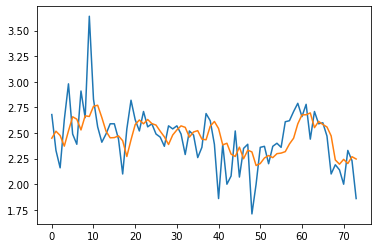

In [ ]:
# report performance
rmse = sqrt(mean_squared_error(raw_val_values, predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_val_values)
pyplot.plot(predictions)
pyplot.show()

In [ ]:
# walk-forward validation on the test data
predictions_test = list()
for i in range(len(test_scaled)):
# make one-step forecast
  X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
  yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
  yhat = invert_scale(scaler, X, yhat)
	# invert differencing
  #yhat = inverse_difference(raw_test_values, yhat, len(test_scaled)+1-i)
	# store forecast
  predictions_test.append(yhat)
  expected = series.values[len(raw_train_values)+len(raw_val_values)+i]
  print('Week=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Week=1, Predicted=1.993653, Expected=2.440000
Week=2, Predicted=2.178811, Expected=2.450000
Week=3, Predicted=2.276561, Expected=2.100000
Week=4, Predicted=2.228421, Expected=2.500000
Week=5, Predicted=2.330855, Expected=2.300000
Week=6, Predicted=2.266918, Expected=2.650000
Week=7, Predicted=2.412682, Expected=2.550000
Week=8, Predicted=2.403752, Expected=2.680000
Week=9, Predicted=2.550107, Expected=2.890000
Week=10, Predicted=2.675145, Expected=2.520000
Week=11, Predicted=2.660451, Expected=3.330000
Week=12, Predicted=2.754196, Expected=2.520000
Week=13, Predicted=2.633504, Expected=2.310000
Week=14, Predicted=2.479200, Expected=2.440000
Week=15, Predicted=2.421260, Expected=2.480000
Week=16, Predicted=2.419472, Expected=2.460000
Week=17, Predicted=2.440546, Expected=2.360000
Week=18, Predicted=2.425036, Expected=2.560000
Week=19, Predicted=2.512684, Expected=1.980000
Week=20, Predicted=2.381614, Expected=2.240000
Week=21, Predicted=2.360322, Expected=2.420000
Week=22, Predicted=2.3

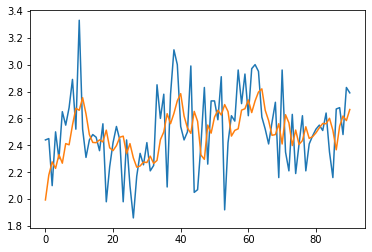

In [ ]:
# line plot of observed vs predicted
pyplot.plot(raw_test_values)
pyplot.plot(predictions_test)
pyplot.show()

In [ ]:
# report performance
rmse = sqrt(mean_squared_error(raw_test_values, predictions_test))
print('Test RMSE: %.3f' % rmse)



Test RMSE: 0.289


In [ ]:
mse = mean_squared_error(raw_test_values, predictions_test)
print('Test MSE: %.3f' % mse)

Test MSE: 0.083


In [ ]:
rolling_residuals = raw_test_values - predictions_test

print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 0.2886820107937824


In [ ]:
ss_res = np.sum(rolling_residuals**2)
ss_tot = np.sum(raw_test_values**2)
R_squared = 1 - (ss_res/ss_tot)
R_squared



0.9869818640306328